In [0]:
#Import neccessary libraries
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


In [196]:
#Mount drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#First Glance at the Data

In [197]:
#Import Data and divide into features (X) and label (y)
data = pd.read_csv('/content/drive/My Drive/Machine Learning/github/practice/parkinson/parkinsons.data')
data.drop('name',axis=1, inplace=True)
X = data.drop('status', axis=1)
y = data.status
print(X.head())
print('X shape:', X.shape)
print('y shape:', y.shape)


   MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  ...   spread2        D2       PPE
0      119.992       157.302        74.997  ...  0.266482  2.301442  0.284654
1      122.400       148.650       113.819  ...  0.335590  2.486855  0.368674
2      116.682       131.111       111.555  ...  0.311173  2.342259  0.332634
3      116.676       137.871       111.366  ...  0.334147  2.405554  0.368975
4      116.014       141.781       110.655  ...  0.234513  2.332180  0.410335

[5 rows x 22 columns]
X shape: (195, 22)
y shape: (195,)


In [198]:
#Check if the data is imbalanced or not
neg, pos = np.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# --> Not imbalanced

Examples:
    Total: 195
    Positive: 147 (75.38% of total)



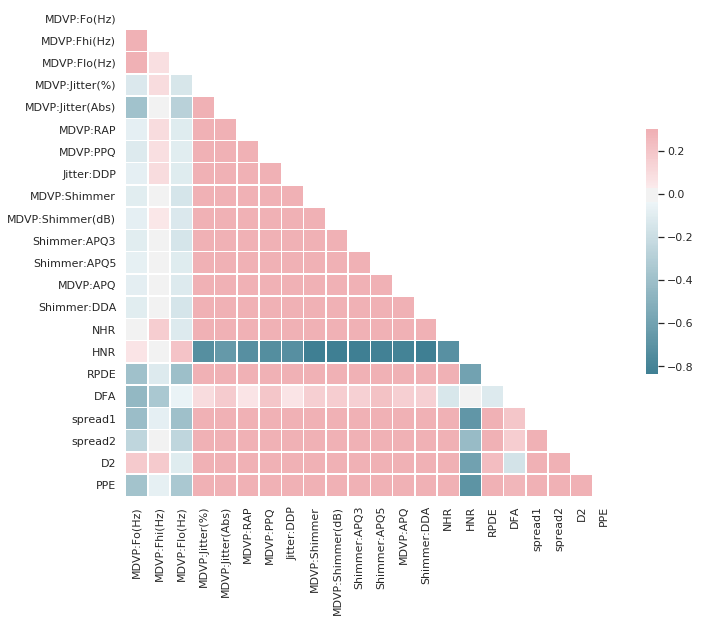

In [199]:
#Draw correlation matrix
sns.set(style="white")

# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Preprocessing

In [318]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=3)
print('training features:', X_train.shape)
print('training labels:', y_train.shape)
print('test size:', X_test.shape)
print('test labels:', y_test.shape)

training features: (117, 22)
training labels: (117,)
test size: (78, 22)
test labels: (78,)


In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Build Baseline Model

In [320]:
model = XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred=model.predict(X_test)

In [322]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, y_pred)

0.8543876567020251

#Tuning

In [0]:
from sklearn.model_selection import cross_val_score,StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

cv = RepeatedStratifiedKFold(n_splits=5, random_state=317)

parameters =    {
            'base_score': [0.7],
            'n_estimators': [100],
            'scale_pos_weight':[1],
            'max_depth':[3],
            'min_child_weight':[1],
            'gamma':[0],
            'subsample':[1],
            'colsample_bytree':[1],
            'reg_alpha':[0],
            'learning_rate':[0.2]            
            }
xgb_model = XGBClassifier(build_fn = model, verbose = 2)

clf = GridSearchCV(xgb_model, param_grid = parameters, scoring = 'roc_auc',   
                         n_jobs = 1, cv = cv)

In [0]:
grid_result = clf.fit(X_train, y_train)


In [0]:
final_model = grid_result.best_estimator_

In [326]:
grid_result.best_score_

0.9363896669779024

In [327]:
y_pred = final_model.predict(X_test)
auc = roc_auc_score(y_test,y_pred)
auc


0.8543876567020251

In [328]:
grid_result.best_params_

{'base_score': 0.7,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.2,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 100,
 'reg_alpha': 0,
 'scale_pos_weight': 1,
 'subsample': 1}